In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import pickle


In [38]:
def logit_transform(score):
    return np.log(score/(1-score))

def filter_df(df):
    df = df[df['bdt_score'] >= 0.5]
    return df 

def Edit_Weight_Tune(df_to_Tune): #This is taken from Aditya's code, Owen also has the same in his for overlay and dirt, there is the same block in PELEE code
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] > 50, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ np.isnan(df_to_Tune['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    return df_to_Tune

def MC_weight_branch(df_MC): 
    df_MC["weight"] = df_MC["ppfx_cv"]*df_MC["weightSplineTimesTune"] 
    return df_MC 

In [48]:
df = pd.read_pickle("E:/run1_NuMI_CV_high_stats_score.pkl")
df = Edit_Weight_Tune(df)
df = MC_weight_branch(df)
df = filter_df(df)
weight_PPFX=df.iloc[:,8]
weight_GENIE=df.iloc[:,9]
weight_Reint=df.iloc[:,10]
cv=df.iloc[:,14]

cv=logit_transform(cv)
PPFX=np.array(weight_PPFX)/1000
GENIE=np.array(weight_GENIE)/1000
Reint=np.array(weight_Reint)/1000


f:\Program Files (x86)\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [40]:
# General histogram settings:
n_x_bins = 8
n_y_bins = 30
xy_binning = (n_x_bins, n_y_bins)
x_binning = np.linspace(0.,5.,n_x_bins + 1)

cmin_treshold = 1e-5

In [49]:
def All_reweight_err(df, var_name, n_bins, x_range, Norm):
    results_dict = {}
    for Multisim in Constants.Multisim_univs:
        Nuniverse = Constants.Multisim_univs[Multisim]
        n_tot = np.empty([Nuniverse, n_bins])
        n_cv_tot = np.empty(n_bins)
        n_tot.fill(0)
        n_cv_tot.fill(0)
        
        variable = df[var_name] #The BDT output score
        syst_weights = df[Multisim] #An array of length of the number of events, each entry is an array of length Nunivs
        spline_fix_cv  = df["weight"]*Norm
        spline_fix_var = df["weight"]*Norm
        
        s = syst_weights
        df_weights = pd.DataFrame(s.values.tolist())
        n_cv, bins = np.histogram(variable, range=x_range, bins=n_bins, weights=spline_fix_cv)
        n_cv_tot += n_cv
        
        if(Multisim == "weightsGenie"): #special treatment as ["weightSplineTimesTune"] is included in genie weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["weightSplineTimesTune"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["weightSplineTimesTune"].iloc[np.isnan(weight)]
                    weight[weight > 50] = df["weightSplineTimesTune"].iloc[weight > 50] # why 30 not 50?
                    weight[weight <= 0] = df["weightSplineTimesTune"].iloc[weight <= 0]
                    weight[weight == np.inf] = df["weightSplineTimesTune"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, 
                                           weights=np.nan_to_num(weight*spline_fix_var/df["weightSplineTimesTune"]), range=x_range, bins=n_bins)
                    n_tot[i] += n
                    
        if(Multisim == "weightsPPFX"): #special treatment as ["PPFXPcv"] is included in ppfx weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["ppfx_cv"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["ppfx_cv"].iloc[np.isnan(weight)]
                    weight[weight > 100] = df["ppfx_cv"].iloc[weight > 100]
                    weight[weight < 0] = df["ppfx_cv"].iloc[weight < 0]
                    weight[weight == np.inf] = df["ppfx_cv"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, weights=weight*np.nan_to_num(spline_fix_var/df["ppfx_cv"]), range=x_range, bins=n_bins)
                    n_tot[i] += n
        
        if(Multisim == "weightsReint"):
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[np.isnan(weight)] = 1
                    weight[weight > 100] = 1
                    weight[weight < 0] = 1
                    weight[weight == np.inf] = 1
                    n, bins = np.histogram(variable, weights=weight*spline_fix_var, range=x_range, bins=n_bins)
                    n_tot[i] += n
        cov = np.empty([len(n_cv), len(n_cv)])
        cov.fill(0)

        for n in n_tot:
            for i in range(len(n_cv)):
                for j in range(len(n_cv)):
                    cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

        cov /= Nuniverse
        results_dict[Multisim] = [cov,n_cv_tot,n_tot,bins]
    return results_dict

In [43]:
def reweight_cv(var,NUniverses):
    n_tot = np.empty([NUniverses,n_x_bins])
    n_cv_tot = np.empty([n_x_bins])
    n_tot.fill(0)
    n_cv_tot.fill(0)



    fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10],dpi=200)
    plt.sca(ax[0])
    plt.xlabel('BDT score')
    plt.ylabel(r'Events')
    plt.title('Run1 BDT score distribution PPFX')

    (counts_std, bins_std) = np.histogram(cv, bins=x_binning)

    n_cv_tot += counts_std 

    i=0
    x=[]
    y=[]


    while i < NUniverses:
        weight=[]
        var_w=[]
        for we in var:
            weight.append(we[i])
        var_w=(weight)
        (counts_we, bins_we) = np.histogram(cv, weights=var_w, bins=x_binning)
        n_tot[i] = counts_we 
        x.append(bins_we[:-1])
        y.append(counts_we)
        i=i+1
    

    cov = np.empty([len(counts_std), len(counts_std)])
    cov.fill(0)    
    for n in n_tot:
        for i in range(len(counts_std)):
            for j in range(len(counts_std)):
                cov[i][j] += (n[i] - n_cv_tot[i])*(n[j] - n_cv_tot[j])
            
    cov /= NUniverses

    
    x=np.array(x)
    ana_x=x.flatten()
    ana_x=ana_x.tolist()
    y=np.array(y)
    ana_y=y.flatten()
    ana_y=ana_y.tolist()  
    plt.hist2d(ana_x,ana_y,bins=xy_binning,range=np.array(([(0., 5), (0., 90.)])),cmin=cmin_treshold)
    plt.hist(bins_std[:-1], bins_std, weights=counts_std ,alpha=0.75, histtype='step',label='CV',color='r',lw=3)
    cb = plt.colorbar()
    plt.xlim(0.,5)
    plt.ylim(0.,90.)
    plt.legend()

    plt.sca(ax[1])
    pos = ax[0].get_position()
    pos2 = ax[1].get_position()
    ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
    plt.hist(bins_std[:-1],bins_std,weights=np.sqrt(np.diag(cov))/n_cv_tot*100, color = "black", histtype="step",lw=3,linestyle="-")
    plt.ylabel("% Uncertainity")
    plt.xlabel("BDT score")
    #plt.ylim(0,100)
    plt.xlim(0.,5.)
    plt.show()

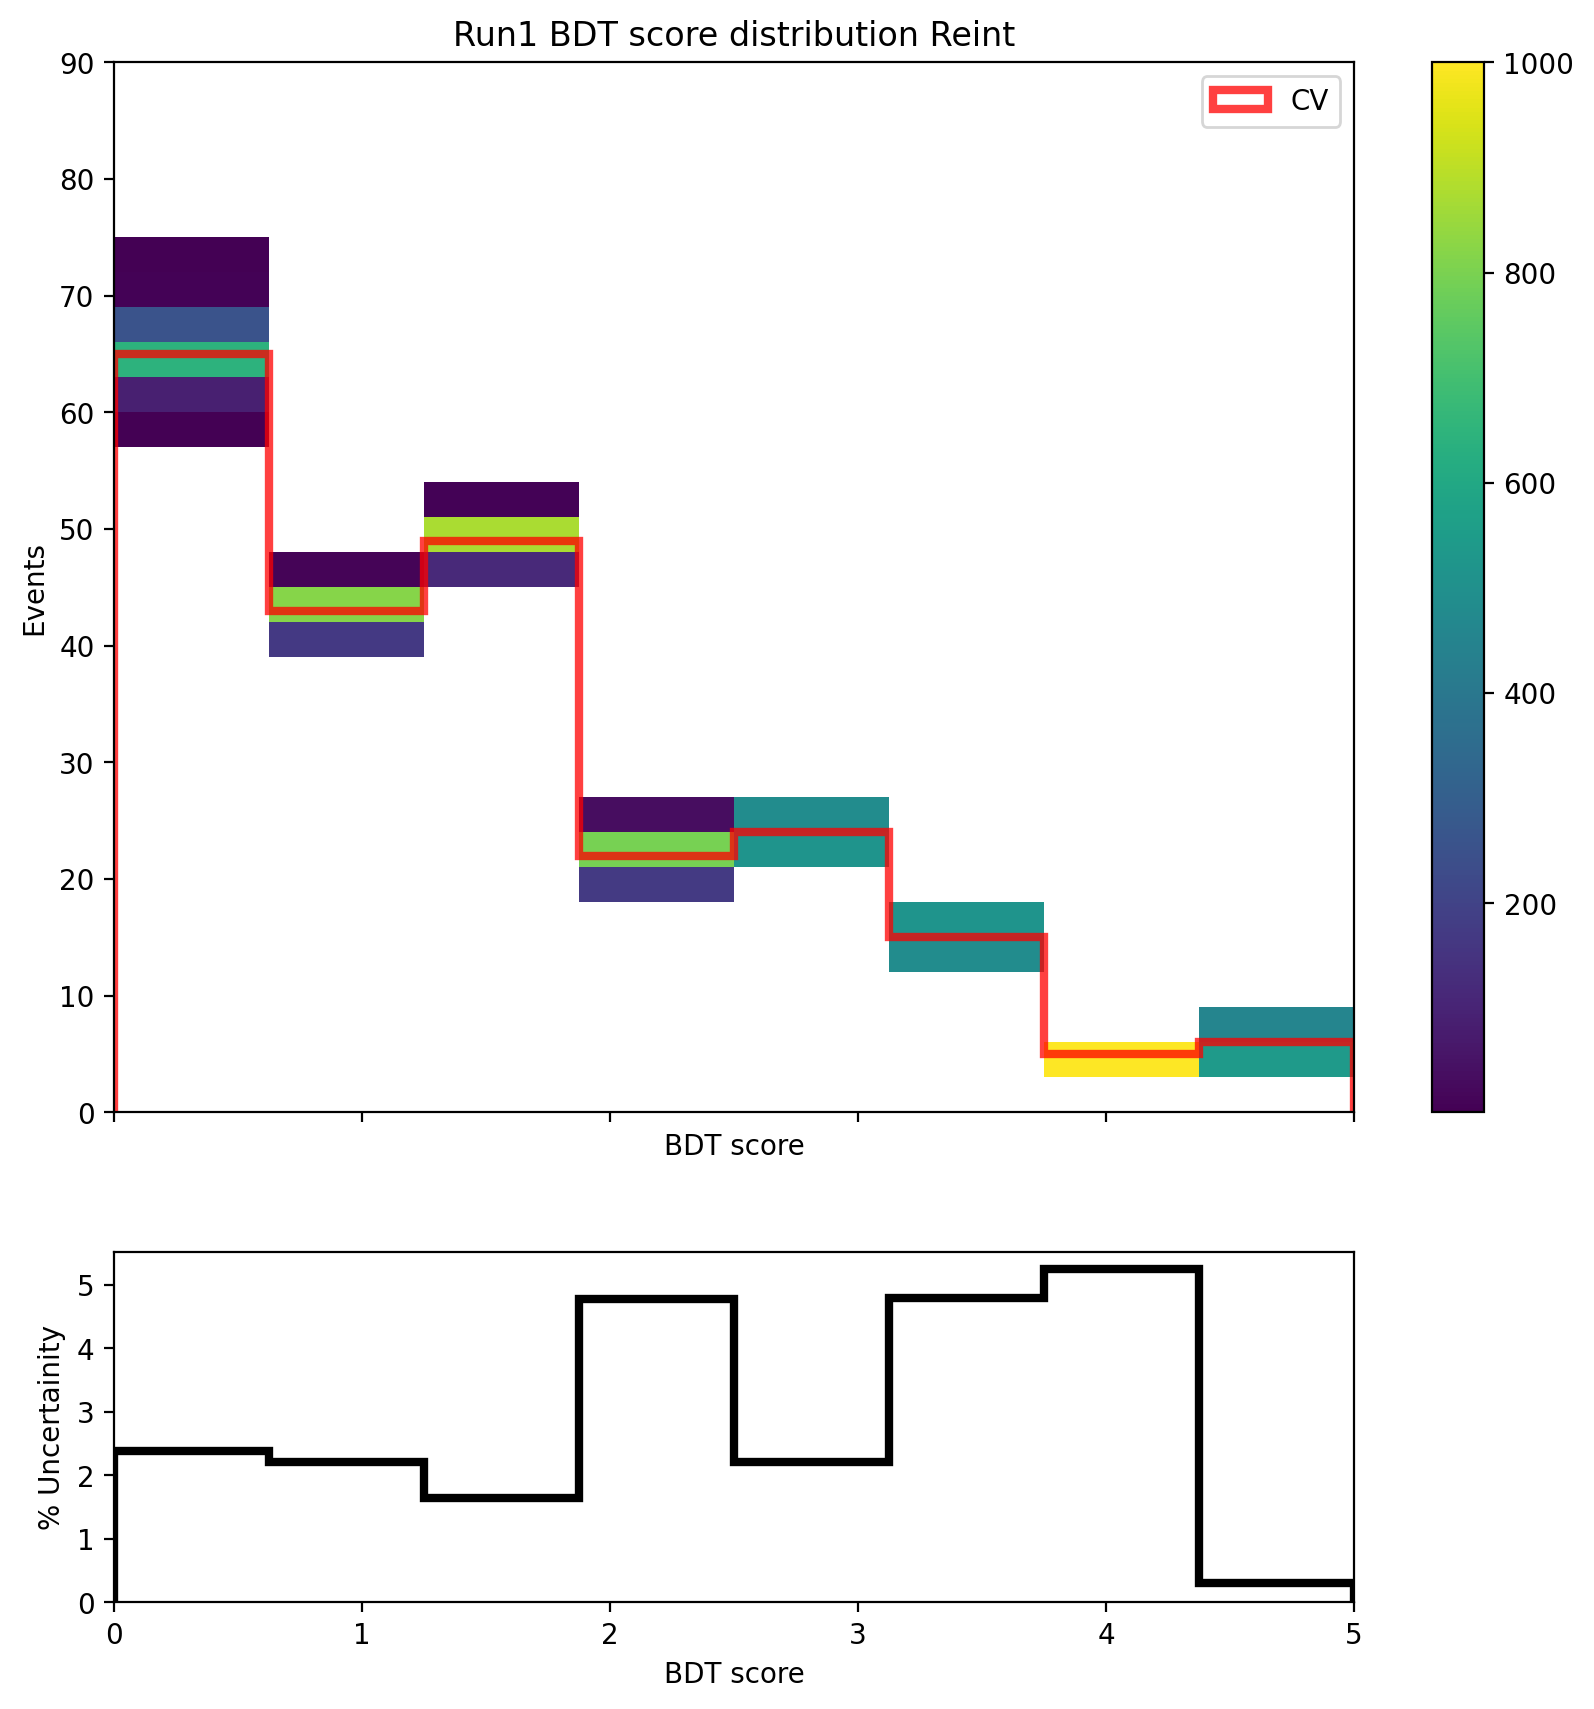

In [29]:
reweight_cv(Reint,1000)

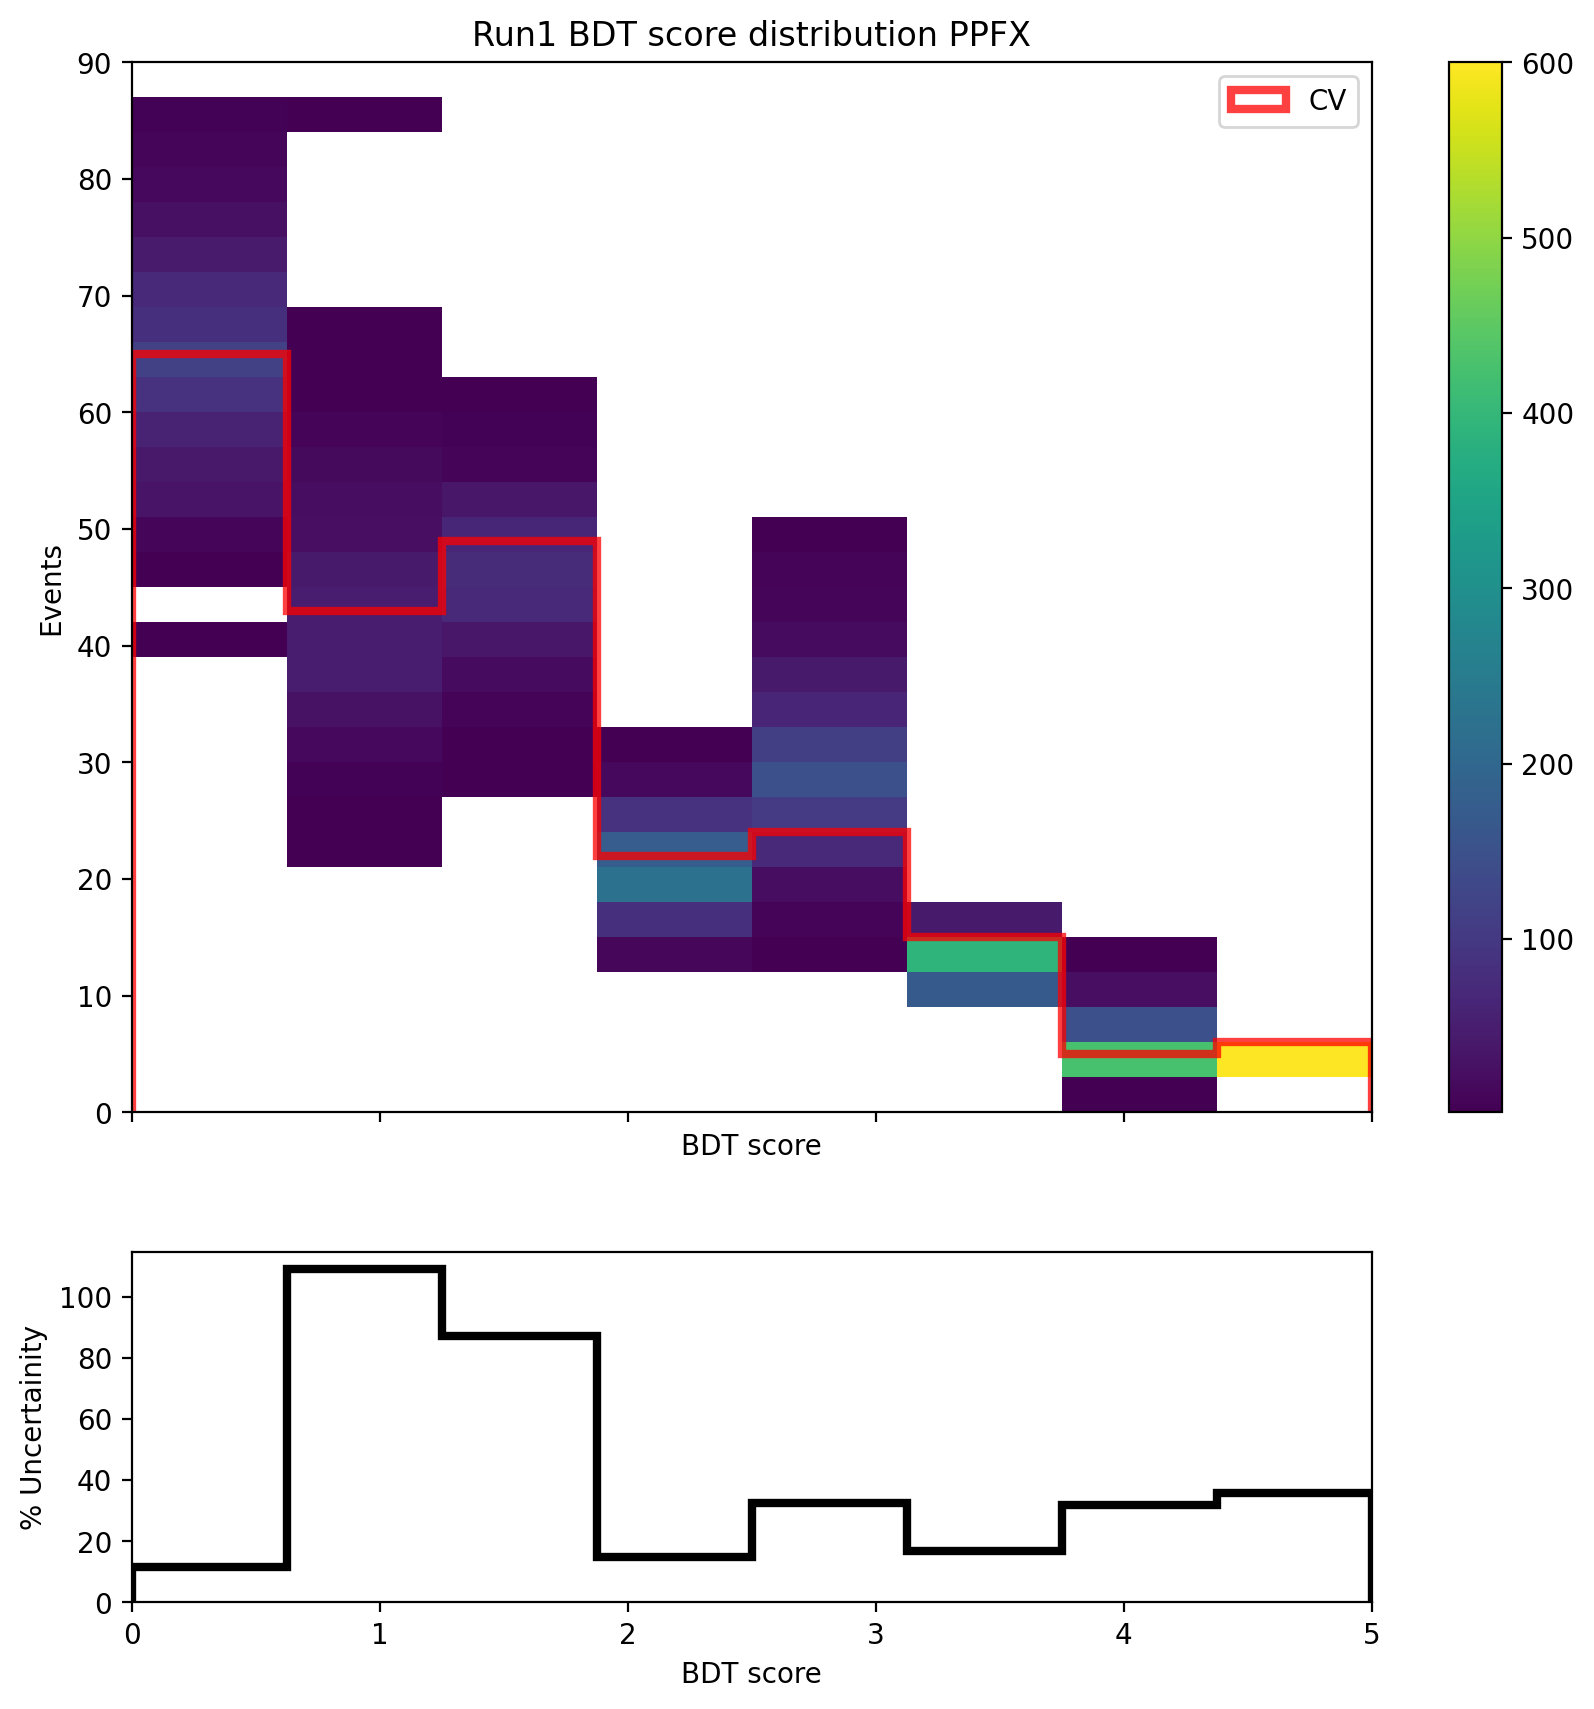

In [44]:
reweight_cv(GENIE,600)

NameError: name 'weight_PP' is not defined

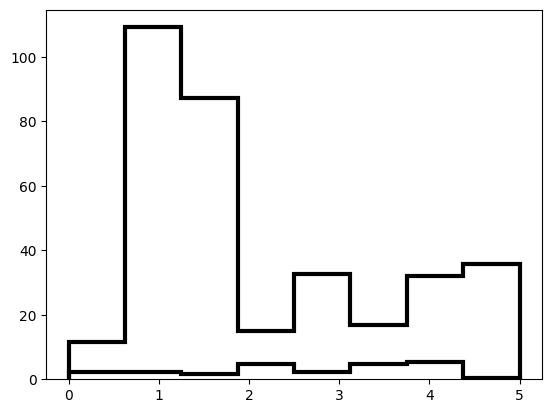